<img width="1000" style="float:center;" src="figures/Heading_tutorial.png"/>

<h1 align="center"><font size="7" face="arial" color="#000000">Simulate an epileptic patient brain</font></h1>

<h3 align="center"><span style="font-weight:normal"><font size="5" face="arial">Julie Courtiol</font></span></h3>

<h3 align="center"><span style="font-weight:normal"><font size="3" face="arial"><a href="mailto:courtiol.julie@gmail.com">courtiol.julie@gmail.com</a></font></span></h3>

<h1><font size="6" face="arial" color="#386766">Pre-requisite</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
<ul>
    <li>Simulate your first virtual brain tutorial</li>
</ul></font></div></p>

<h1><font size="6" face="arial" color="#386766">Context</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
<b>Epilepsy</b> is one of the most common neurological disorder that is defined by the occurrence of repetitive unexpected seizures. These epileptic seizures, characterized as abnormal synchronization of neural activities, originate in a specific set of brain regions, known as the <b>Epileptique Zone (EZ)</b>, and propagate to other regions, the <b>Propagation Zone (PZ)</b>, through inter-regional structural interactions, i.e., individual brain connectome, and produce various ictal symptoms depending on the recruited brain regions.
</font></div></p>

<br><h1><font size="6" face="arial" color="#386766">Objective</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman">The main goal of this hands-on is to provide a clear understanding of <b>how we can reproduce clinically relevant scenarios</b> such as the modelisation of the <b>propagation of an epileptic seizure</b> in a human brain.</font></div></p>

<br><h1><font size="6" face="arial" color="#386766">How to do it with TVB?</font></h1> 

---

<p><div style="text-align: justify"><font size="4.5" face="time roman">The first thing we need to do, is to import the necessary TVB modules and some additional Python packages to perform the simulation and visualize our results.</font></div></p>

In [1]:
# Online visualization.
%pylab nbagg

# Import tvb library.
from tvb.simulator.lab import *
import tvb.datatypes.projections as projections

# Import a bunch of stuff to ease command line usage.
import os
import numpy as np
import time as tm

Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


<h1><font size="6" face="arial" color="black">1. Build a virtual epileptic patient</font></h1>
<br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">In the following, we will model a random patient suffering from a <b>bilateral temporal lobe epilepsy (TLE)</b> using the Default TVB Subject dataset.</font></div></p> <br>

<p><div style="text-align: justify"><font size="4.5" face="time roman">To make things fully transparent, we will load the files from our local copy. To follow, change the path to the location of the dataset on your machine:</font></div></p>

In [2]:
datadir = "/Applications/TVB_Distribution/my_tvb_materials/TVB_NODES/TVB Node 10/my_pres/notebook/dataset/"

<br><p><div style="text-align: justify"><font size="4.5" face="time roman">The basic simulation of TVB consists of <b>5 main components</b>. Each of these components is an object within TVB:</font></div></p>

<h2><font size="5"face="arial" color="black"> 1.1 Anatomical Structural Connectivity</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We start with loading and visualizing the structural connectivity matrix of the patient.</font></div></p>

WARNING  File 'hemispheres' not found in ZIP.


<IPython.core.display.Javascript object>


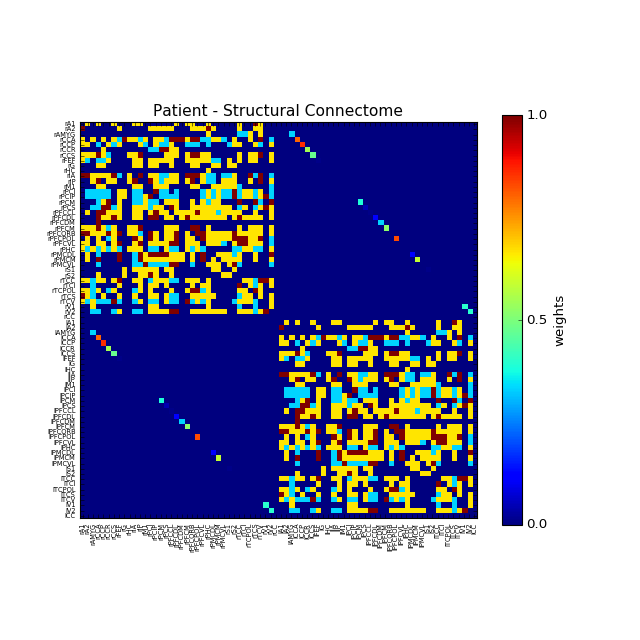

In [3]:
# Initialise a Connectivity.
con = connectivity.Connectivity.from_file(os.path.join(datadir,"connectivity_76.zip"))       
nregions = len(con.areas)                                  #number of regions
con.weights = con.weights - con.weights * np.eye(nregions) #remove self-connections
con.weights = con.weights / np.abs(con.weights.max())      #normalize
con.speed = np.inf                                         #set the conduction speed to infinity (no time delays)
con.configure()

# Visualization.
figure(figsize=(8,8))
imshow(con.weights, interpolation='nearest', aspect='equal', cmap='jet')
title('Patient - Structural Connectome', fontsize=14)
cb=colorbar(shrink=0.8, ticks=[0, .5, 1])
cb.set_label('weights')
xticks(range(0, nregions), con.region_labels, fontsize=6, rotation=90)
yticks(range(0, nregions), con.region_labels, fontsize=6)
show()

<h2><font size="5" face="arial" color="black"> 1.2 Model</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">In order to model epilepsy, we choose the <b>Epileptor</b> which is a phenomenological neural mass model able to realistically reproduce <b>epileptic seizure dynamics</b> such as recorded with intracranial EEG electrodes (see <b>Jirsa et al., Brain 2014</b>):</font></div></p>

\begin{eqnarray}
    \dot{x}_{1} &=& y_{1} - f_{1}(x_{1}, x_{2}) - z + I_{ext_{1}}\\
    \dot{y}_{1} &=& 1 - 5x_{1}^{2} - y_{1}\\
    \dot{z} &=& \dfrac{1}{\tau_{0}} \ (4 (x_{1} - \color{blue}{x_{0}}) - z)\\
    \dot{x}_{2} &=& - y_{2} + x_{2} - x_{2}^{3} + I_{ext_{2}} + 0.002g(x_{1}) - 0.3 (z - 3.5)\\
    \dot{y}_{2} &=& \dfrac{1}{\tau_{2}} \ (-y_{2} + f_{2}(x_{2}))\\
\end{eqnarray}

<p><div style="text-align: justify"><font size="4.5" face="time roman">where $\tau_{0}=2857$, $I_{ext_{1}}=3.1$, $I_{ext_{2}}=0.45$. The parameter $\pmb{x_{0}}$ controls the degree of <b>epileptogenicity</b> (or excitability) of the node:

<br>
<ul><li>if $\pmb{x_{0} \geqslant x_{0, c}}$, the Epileptor can trigger seizures and is said <b>epileptogenic</b>,</li>

<br><li>inversely, if $\pmb{x_{0} < x_{0, c}}$, the Epileptor does not trigger seizure and is said <b>not epileptogenic</b> (or in its "healthy" equilibrium state).</li></ul>

<img width="500" style="float:center;" src="figures/epilepsy_epileptor_x0.png"/>


<br>See equations page 8 in Jirsa et al. (2014) for more details on the model.</font></div></p><br>

In [4]:
# Initialise a Model.
epi = models.Epileptor(Ks=1., r=0.00015) # in Jirsa et al. (2014): r = 1/ \tau_0

# Set initial conditions in fixed point.
epi.state_variable_range["x1"] = [-5, -3]
epi.state_variable_range["y1"] = [-50, -50]
epi.state_variable_range["z"] = [4., 6.]
epi.state_variable_range["x2"] = [-1.1, 1.1]
epi.state_variable_range["y2"] = [0.001, 0.01]

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can refine the network pathology of the patient by including the clinical hypothesis about its <b>Epileptogenic Network</b>. To this end, we define a <b>spatial map of epileptogenicity</b> where each network's node <i>i</i> is characterized by an excitability value $\pmb{x_{0,i}}$, which quantifies the ability of the node to trigger a seizure. 
<br>We set:
<ul>
<li>the hippocampus (rHC, region 9 and lHC, region 47) as well as the amydala (rAMYG, region 2 and lAMYG, region 40)
as part of the <b>Epileptogenic Zone (EZ)</b>, with an epileptogenicity parameter value $\pmb{x_{0,i}}$ equal to <b>-1.4</b> for the rHC and <b>-1.6</b> for the lHC and l-rAMYG,</li> 
<li>we also add two lesser epileptogenic regions: the parahippocampal (lPHC, region 62) and the temporal pole (lTPOL, region 70) as part of the <b>Propagation Zone (PZ)</b>, with an epileptogenicity parameter value $\pmb{x_{0,i}}$ equal to <b>-1.7</b> and <b>-1.8</b>, respectively,</li>
<li>and all the other regions (or <b>Non-Involved Zone, NIZ</b>) are set to <b>-2.6</b>.</li>
</ul>

<img width="250" style="float:center;" src="figures/epilepsy_heatmap.png" />

In [5]:
# Define a heatmap.
epi.x0 = np.ones(nregions) * (-2.6)           #NIZ
epi.x0[[9]] = np.ones((1)) * (-1.4)           #EZ 
epi.x0[[47, 2, 40]] = np.ones((3)) * (-1.6)   #EZ 
epi.x0[[62]] = np.ones((1)) * (-1.7)          #PZ 
epi.x0[[70]] = np.ones((1)) * (-1.8)          #PZ 

<h2><font size="5"face="arial" color="black"> 1.3 Coupling function</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We couple the Epileptors by <b>permittivity coupling</b> (see Proix et al., 2014), which quantifies the influence of neuronal fast discharges $x_{1,j}$ of a remote region $j$ on the local slow permittivity variable $z_{i}$ of region $i$ via a linear <b>difference coupling</b> function, allowing the spread of the seizure through the network by recruiting regions that are not in the EZ.</font></div></p>

\begin{eqnarray}
    \dot{x}_{1,i} &=& y_{1,i} - f_{1}(x_{1,i}, x_{2,i}) - z_{i} + I_{ext_{1}}\\
    \dot{y}_{1,i} &=& 1 - 5x_{1,i}^{2} - y_{1,i}\\
    \dot{z}_{i} &=& \dfrac{1}{\tau_{0}} \ (4 (x_{1,i} - x_{0,i}) - z_{i} \color{red}{- K_{s} * G \ \sum_{j=1}^{N}C_{ij}(x_{1,j} - x_{1,i}))}\\
    \dot{x}_{2,i} &=& - y_{2,i} + x_{2,i} - x_{2,i}^{3} + I_{ext_{2}} + 0.002g(x_{1,i}) - 0.3 (z_{i} - 3.5)\\
    \dot{y}_{2,i} &=& \dfrac{1}{\tau_{2}} \ (-y_{2,i} + f_{2}(x_{2,i}))\\
\end{eqnarray}

In [6]:
# Initialise a Coupling function.
G = -0.25      #global (long-range) coupling strength
con_coupling = coupling.Difference(a=G)

<h2><font size="5"face="arial" color="black"> 1.4 Integrator</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We employ a standard <b>Heun method</b> with an integration time step of <b>0.05</b>. <b>Additive white Gaussian noise</b> is introduced in the state-variables $\pmb{x_{2,i}}$ and $\pmb{y_{2,i}}$ with 0 mean and variance <b>0.00025</b>.</font></div></p>

In [7]:
# Initialise an Integrator scheme.
dt = 0.05               #integration steps [ms]
nsigma = 0.00025        #standard deviation of the noise

hiss = noise.Additive(nsig=np.array([0., 0., 0., nsigma, nsigma, 0.])) 
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

<h2><font size="5"face="arial" color="black"> 1.5 Monitors</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Here, we will select (1) a simple data reduction monitor and (2) a biophysical measurement process to relate the simulated neural activity to recent epilepsy studies: 

<ol type="1">
<li>the <b>TemporalAverage</b> monitor averages over a time window of length <i>period</i> returning one time point every <i>period</i> ms,</li>
<li>the <b>iEEG</b> monitor generates SEEG recordings.</li>
</ol>
</font></div></p>

In [8]:
# Initialise some Monitors with period in physical time.
#Temporal Average
mon_tavg = monitors.TemporalAverage(period=1) #in ms

#SEEG
#Load the default region mapping
rm = region_mapping.RegionMapping.from_file(os.path.join(datadir, "regionMapping_16k_76.txt"))

mon_seeg = monitors.iEEG.from_file(
            sensors_fname=os.path.join(datadir, "seeg_588.txt"),
            projection_fname=os.path.join(datadir, "projection_seeg_588_surface_16k.npy"),
            region_mapping=rm,
            period=1.)

what_to_watch = (mon_tavg, mon_seeg)

<h1><font size="6" face="arial" color="black">2. The simulation</font></h1>
<br>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can then configure and run the <b>Simulator</b>.</font></div></p>

In [9]:
# Initialise the Simulator.
sim = simulator.Simulator(connectivity=con,
                          conduction_speed=np.float(con.speed),
                          model=epi,
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=what_to_watch)

sim.configure()

Parameter,Value,Description
initial_conditions,None,"Initial conditions from which the simulation will begin. By default, random initial conditions are provided. Needs to be the same shape as simulator 'history', ie, initial history function which defines the minimal initial state of the network with time delays before time t=0. If the number of time points in the provided array is insufficient the array will be padded with random values based on the 'state_variables_range' attribute."
coupling,Difference(a=-0.25),The coupling function is applied to the activity propagated between regions by the ``Long-range connectivity`` before it enters the local dynamic equations of the Model. Its primary purpose is to 'rescale' the incoming activity to a level appropriate to Model.
stimulus,None,"A ``Spatiotemporal stimulus`` can be defined at the region or surface level. It's composed of spatial and temporal components. For region defined stimuli the spatial component is just the strength with which the temporal component is applied to each region. For surface defined stimuli, a (spatial) function, with finite-support, is used to define the strength of the stimuli on the surface centred around one or more focal points. In the current version of TVB, stimuli are applied to the first state variable of the ``Local dynamic model``."
integrator,"HeunStochastic(dt=0.05, noise=Additive(dt=0.05, ntau=0))",A tvb.simulator.Integrator object which is an integration scheme with supporting attributes such as integration step size and noise specification for stochastic methods. It is used to compute the time courses of the model state variables.
surface,None,"By default, a Cortex object which represents the cortical surface defined by points in the 3D physical space and their neighborhood relationship. In the current TVB version, when setting up a surface-based simulation, the option to configure the spatial spread of the ``Local Connectivity`` is available."
connectivity,"Connectivity(bound=False, value=None)","A tvb.datatypes.Connectivity object which contains the structural long-range connectivity data (i.e., white-matter tracts). In combination with the ``Long-range coupling function`` it defines the inter-regional connections. These couplings undergo a time delay via signal propagation with a propagation speed of ``Conduction Speed``"
conduction_speed,inf,Conduction speed for ``Long-range connectivity`` (mm/ms)
simulation_length,1000.0,The length of a simulation (default in milliseconds).
model,"Epileptor(bound=False, value=None)","A tvb.simulator.Model object which describe the local dynamic equations, their parameters, and, to some extent, where connectivity (local and long-range) enters and which state-variables the Monitors monitor. By default the 'Generic2dOscillator' model is used. Read the Scientific documentation to learn more about this model."
monitors,"(TemporalAverage(bound=False, value=None), iEEG(bound=False, value=None))","A tvb.simulator.Monitor or a list of tvb.simulator.Monitor objects that 'know' how to record relevant data from the simulation. Two main types exist: 1) simple, spatial and temporal, reductions (subsets or averages); 2) physiological measurements, such as EEG, MEG and fMRI. By default the Model's specified variables_of_interest are returned, temporally downsampled from the raw integration rate to a sample rate of 1024Hz."


In [10]:
# Starting simulation.
print("Starting simulation...")
tic = tm.time()
(ttavg, tavg), (tseeg, seeg) = sim.run(simulation_length=10000) 

# Finished simulation. 
print("Finished simulation.")
print("execute for" + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for63.0929880142


<p><div style="text-align: justify"><font size="4.5" face="time roman">And finally, we can look at the results of our simulation in terms of time series:</font></div></p>

In [11]:
# Normalize the time series to have nice plots.
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
tavg -= np.mean(tavg, 0)
seeg /= (np.max(seeg,0) - np.min(seeg, 0))
seeg -= np.mean(seeg, 0)

<IPython.core.display.Javascript object>


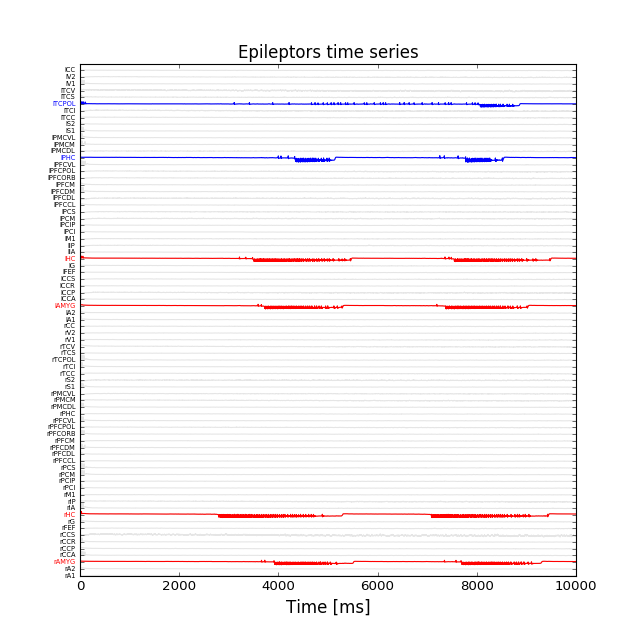

In [12]:
# Plot source activity time series.
fig, ax  = subplots(figsize=(8,8))

ax.plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:nregions], 'k', alpha=0.1)
title('Epileptors time series', fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=6)

EZs = [9, 47, 2, 40]
for iez, ez in enumerate(EZs):
    ax.plot(ttavg[:], tavg[:, 0, EZs[iez], 0] + EZs[iez], 'r')
    ax.get_yticklabels()[EZs[iez]].set_color('r')

PZs = [62, 70]
for ipz, pz in enumerate(PZs):
    ax.plot(ttavg[:], tavg[:, 0, PZs[ipz], 0] + PZs[ipz], 'b')
    ax.get_yticklabels()[PZs[ipz]].set_color('b')
    
show()

<IPython.core.display.Javascript object>


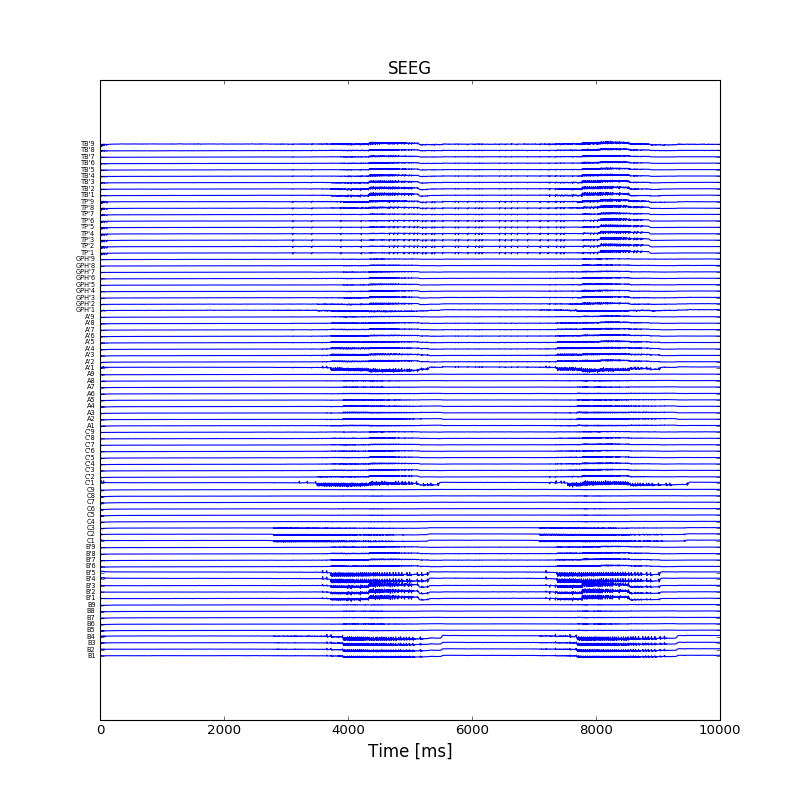

In [13]:
# Plot the selected SEEG sensors recordings.
#SEEG sensors 
contacts = np.r_[np.arange(27, 36), np.arange(321, 330), #B(rHC) - B'(lHC)
                 np.arange(36, 45), np.arange(330, 339), #C(rHC) - C'(lHC)
                 np.arange(18, 27), np.arange(312, 321), #NA(rA) - NA'(lA)
                 np.arange(339, 348), #GPH'(lPHC)
                 np.arange(294, 303), #TP'(lTP)
                 np.arange(303, 312) # TB' (lTl basalis)
                  ]

figure(figsize=(10,10))
plot(tseeg[:], seeg[:, 0, contacts, 0] + np.r_[:len(contacts)], 'b')
yticks(np.r_[:len(contacts)], mon_seeg.sensors.labels[contacts], fontsize=6)
title('SEEG', fontsize=15)
xlabel('Time [ms]', fontsize=15)
show()

<h1><font size="6" face="arial" color="##000000">That is all folks</font></h1>

***

<p><div style="text-align: justify"><font size="4.5" face="time roman">I hope this has been a useful tutorial and welcome any comments or questions.</font></div></p>

<br><p><div style="text-align: justify"><font size="4.5" face="time roman"><u>References</u></font></div></p>
* Jirsa et al., 2014: 

Jirsa, V. K.; Stacey, W. C.; Quilichini, P. P.; Ivanov, A. I.; Bernard, C. <b>On the nature of seizure dynamics</b>. <i>Brain</i>, 2014; 137: 2210–30.

* Proix et al., 2014:

Proix, T; Bartolomei, F.; Chauvel, P.; Bernard, C.; Jirsa, V. K. <b>Permittivity coupling across brain regions determines seizure recruitment in partial epilepsy</b>. <i>J of Neurosci</i>, 2014; 34(45):15009 –15021.